In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats as ssd
seed = 2137

In [2]:
#read the data
spx = pd.read_csv('^spx_d.csv', parse_dates=['Date'], index_col='Date', header=0, names=['Date','Open','High','Low','SPX','Volume']).drop(['Open','High','Low','Volume'], axis=1)
dax = pd.read_csv('^dax_d.csv', parse_dates=['Date'], index_col='Date', header=0, names=['Date','Open','High','Low','DAX','Volume']).drop(['Open','High','Low','Volume'], axis=1)
wig = pd.read_csv('wig20_d.csv', parse_dates=['Date'], index_col='Date', header=0, names=['Date','Open','High','Low','WIG20','Volume']).drop(['Open','High','Low','Volume'], axis=1)
fx = pd.read_csv('eurusd_d.csv', parse_dates=['Date'], index_col='Date', header=0, names=['Date','Open','High','Low','EURUSD']).drop(['Open','High','Low'], axis=1)

In [3]:
#join into one dataframe
data_full = pd.concat([spx, dax, wig, fx], axis=1, join='outer')
data_full.index = pd.DatetimeIndex(data_full.index.values, freq=data_full.index.inferred_freq)

#forward fill for missing data
data_full.asfreq('B').ffill(inplace=True)
data_full

,SPX,DAX,WIG20,EURUSD
2010-01-04,1132.99,6048.30,2444.58,1.44120
2010-01-05,1136.52,6031.86,2462.30,1.43610
2010-01-06,1137.14,6034.33,2472.83,1.43990
2010-01-07,1141.69,6019.36,2436.40,1.43040
2010-01-08,1144.98,6037.61,2440.42,1.43980
...,...,...,...,...
2022-03-14,4173.11,13929.11,1972.14,1.09348
2022-03-15,4262.45,13917.27,1999.93,1.09649
2022-03-16,4357.86,14440.74,2060.07,1.10183
2022-03-17,4411.67,14388.06,2125.29,1.10938


In [4]:
columns = ['SPX','DAX','WIG20','EURUSD']

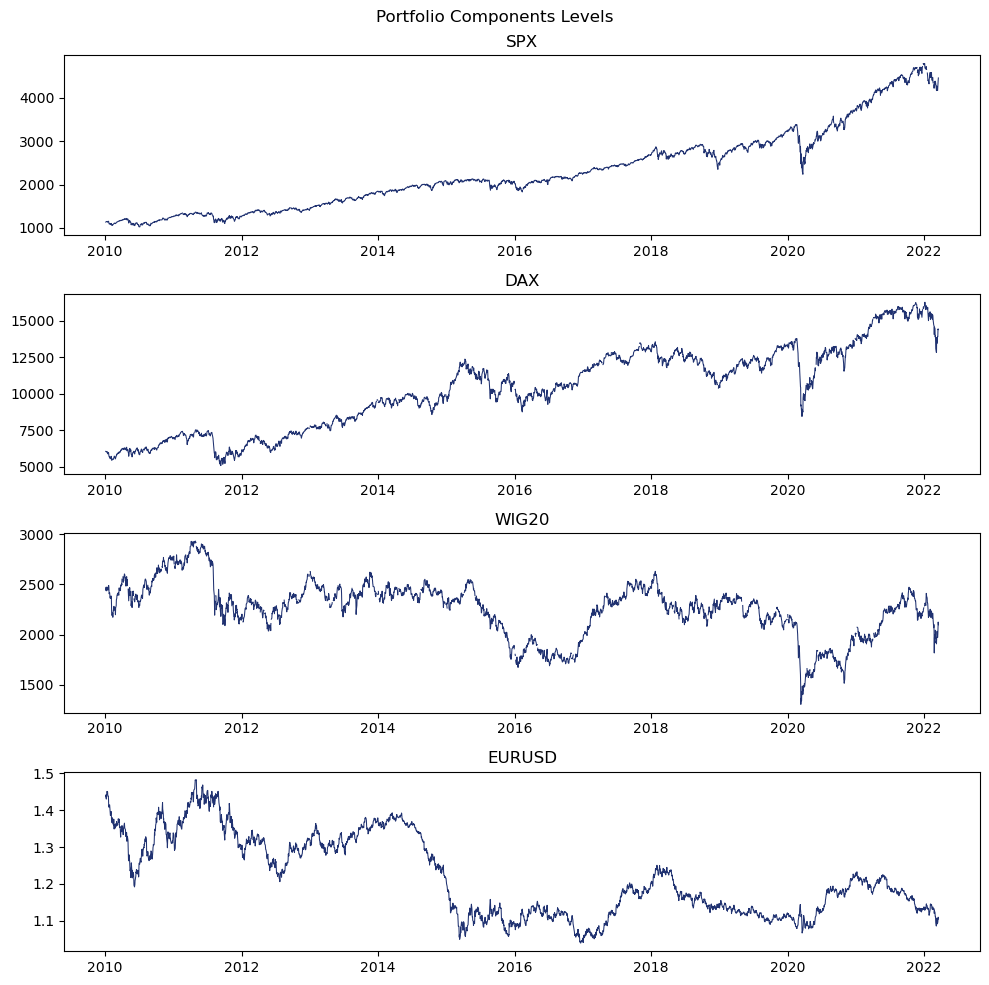

In [5]:
#plot the data
fig, ax = plt.subplots(4, 1, dpi=100, figsize=(10,10))
plt.suptitle('Portfolio Components Levels')

a=0
for i in columns:
    ax[a].plot(data_full[i], c='#203271', lw=.75)
    ax[a].set_title('%s' %i)
    a += 1
    
plt.tight_layout()
plt.show()
fig.savefig('levels.pdf', bbox_inches='tight')

In [6]:
#convert to logarithmic rates of return
data_log = np.log(data_full)
data_log_ret = pd.DataFrame(data_log.diff().dropna()*100)
data_log_ret.head()

,SPX,DAX,WIG20,EURUSD
2010-01-05,0.311081,-0.272182,0.722254,-0.354499
2010-01-06,0.054538,0.040941,0.426737,0.264256
2010-01-07,0.399328,-0.248389,-1.484170,-0.661954
2010-01-08,0.287755,0.302730,0.164862,0.655009
2010-01-11,0.174523,0.047855,1.346400,0.788659


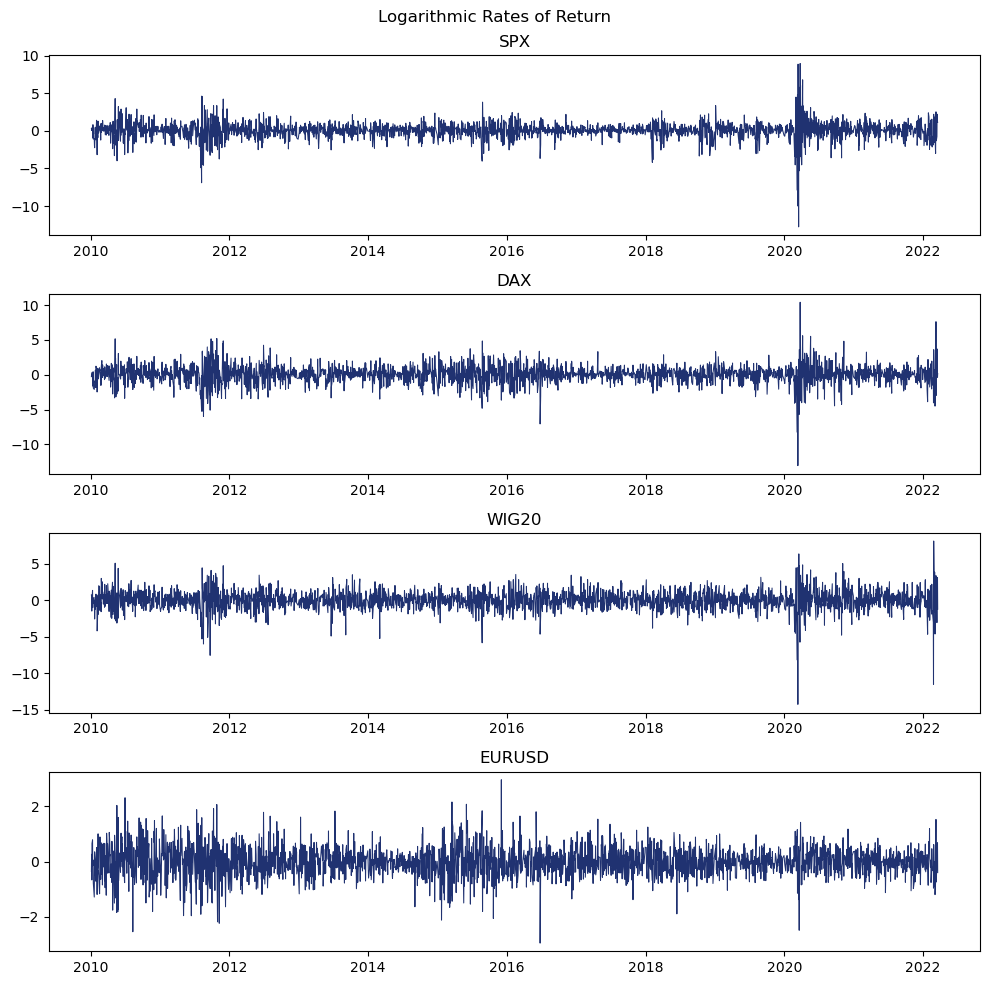

In [7]:
#plot logarithmic rates of return
fig, ax = plt.subplots(4, 1, dpi=100, figsize=(10,10))
plt.suptitle('Logarithmic Rates of Return')

a=0
for i in columns:
    ax[a].plot(data_log_ret[i], c='#203271', lw=.75)
    ax[a].set_title('%s' %i)
    a += 1
    
plt.tight_layout()
plt.show()
fig.savefig('returns.pdf', bbox_inches='tight')

In [8]:
#stationarity test for each time series
from statsmodels.tsa.stattools import adfuller

data_full_2 = data_full.dropna()

for i in columns:
    print('ADF test p-value for', i,': ',adfuller(data_full_2[i].values)[1])

ADF test p-value for SPX :  0.9906412641963869
ADF test p-value for DAX :  0.6282162269967391
ADF test p-value for WIG20 :  0.070189370689203
ADF test p-value for EURUSD :  0.21235300692837433


In [9]:
#stationarity test for each time series
from statsmodels.tsa.stattools import adfuller

for i in columns:
    print('ADF test p-value for', i,': ',adfuller(data_log_ret[i].values)[1])

ADF test p-value for SPX :  7.36446315082116e-28
ADF test p-value for DAX :  0.0
ADF test p-value for WIG20 :  0.0
ADF test p-value for EURUSD :  0.0


In [10]:
#autocorrelation test for each time series
acorr = []
for i in columns:
    acorr.append([sm.stats.acorr_ljungbox(data_log_ret[i].values, lags=5, return_df=True)['lb_pvalue']])
pd.DataFrame(acorr, index=columns, columns=['lag p-value'])

,lag p-value
SPX,1 2.780542e-15 2 3.986785e-21 3 3.102...
DAX,1 0.935201 2 0.715117 3 0.822763 4 ...
WIG20,1 0.850373 2 0.428052 3 0.636519 4 ...
EURUSD,1 0.312634 2 0.305729 3 0.452213 4 ...


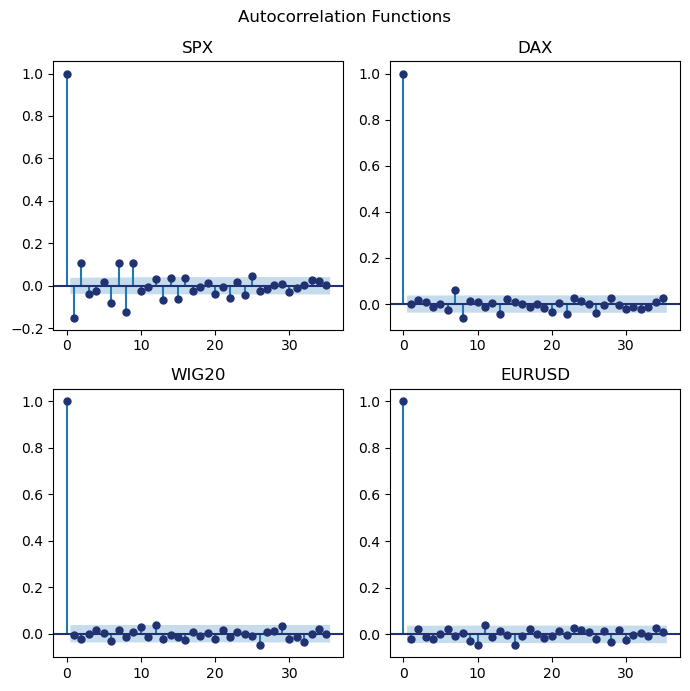

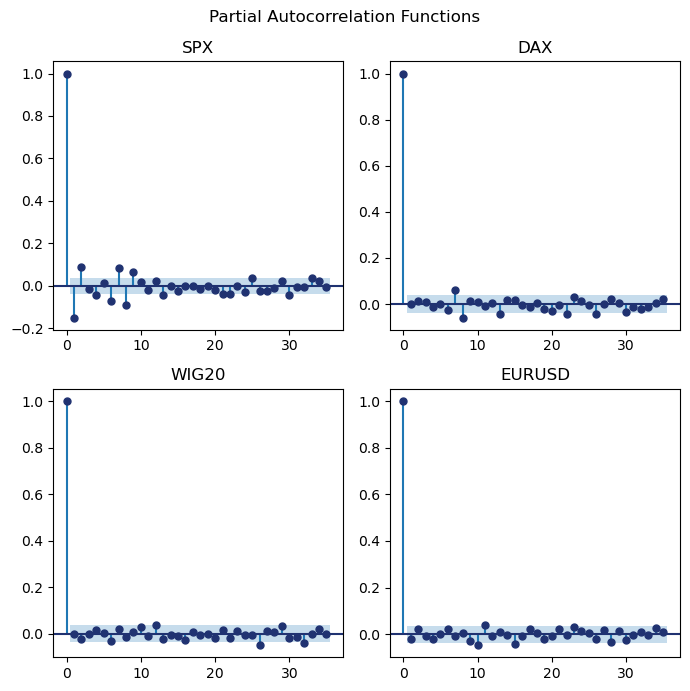

In [11]:
#ACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 2, dpi=100, figsize=(7,7))
plt.suptitle('Autocorrelation Functions')

plot_acf(data_log_ret['SPX'], ax=ax[0][0], color='#203271')
ax[0][0].set_title('SPX')
plot_acf(data_log_ret['DAX'], ax=ax[0][1], color='#203271')
ax[0][1].set_title('DAX')
plot_acf(data_log_ret['WIG20'], ax=ax[1][0], color='#203271')
ax[1][0].set_title('WIG20')
plot_acf(data_log_ret['EURUSD'], ax=ax[1][1], color='#203271')
ax[1][1].set_title('EURUSD')

plt.tight_layout()
plt.show()
fig.savefig('ACF.pdf', bbox_inches='tight')

#PACF plots
fig, ax = plt.subplots(2, 2, dpi=100, figsize=(7,7))
plt.suptitle('Partial Autocorrelation Functions')

plot_pacf(data_log_ret['SPX'], ax=ax[0][0], color='#203271')
ax[0][0].set_title('SPX')
plot_pacf(data_log_ret['DAX'], ax=ax[0][1], color='#203271')
ax[0][1].set_title('DAX')
plot_pacf(data_log_ret['WIG20'], ax=ax[1][0], color='#203271')
ax[1][0].set_title('WIG20')
plot_pacf(data_log_ret['EURUSD'], ax=ax[1][1], color='#203271')
ax[1][1].set_title('EURUSD')

plt.tight_layout()
plt.show()
fig.savefig('PACF.pdf', bbox_inches='tight')

In [12]:
#split for benchmark study - 01/2010-12/2011
data_bench = data_log_ret.loc[:'2011-12-30']
data_bench.head()

,SPX,DAX,WIG20,EURUSD
2010-01-05,0.311081,-0.272182,0.722254,-0.354499
2010-01-06,0.054538,0.040941,0.426737,0.264256
2010-01-07,0.399328,-0.248389,-1.484170,-0.661954
2010-01-08,0.287755,0.302730,0.164862,0.655009
2010-01-11,0.174523,0.047855,1.346400,0.788659


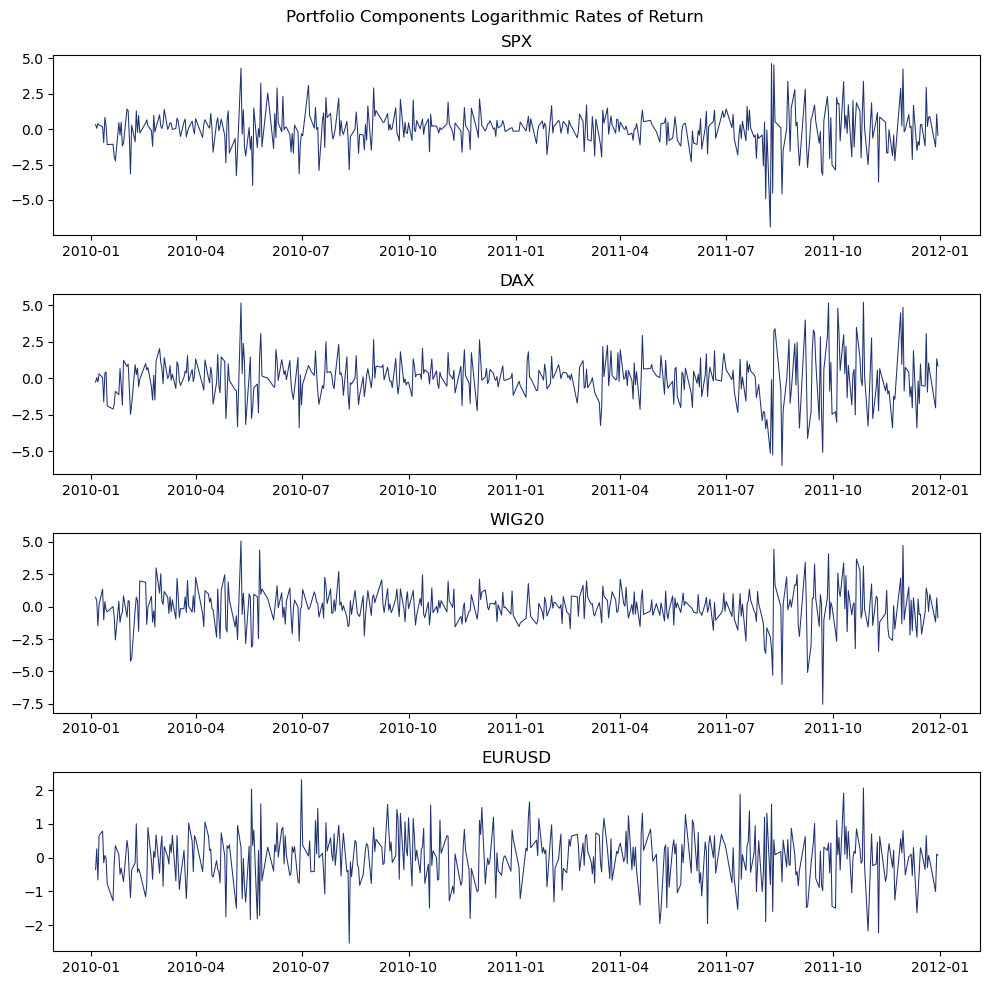

In [13]:
#plot the data
fig, ax = plt.subplots(4, 1, dpi=100, figsize=(10,10))
plt.suptitle('Portfolio Components Logarithmic Rates of Return')

a=0
for i in columns:
    ax[a].plot(data_bench[i], c='#203271', lw=.75)
    ax[a].set_title('%s' %i)
    a += 1
    
plt.tight_layout()
plt.show()
fig.savefig('levels_bench.pdf', bbox_inches='tight')

In [14]:
#data for the study
data = data_log_ret.loc['2012-01-02':]
data.head()
data.to_csv('study_data.csv')

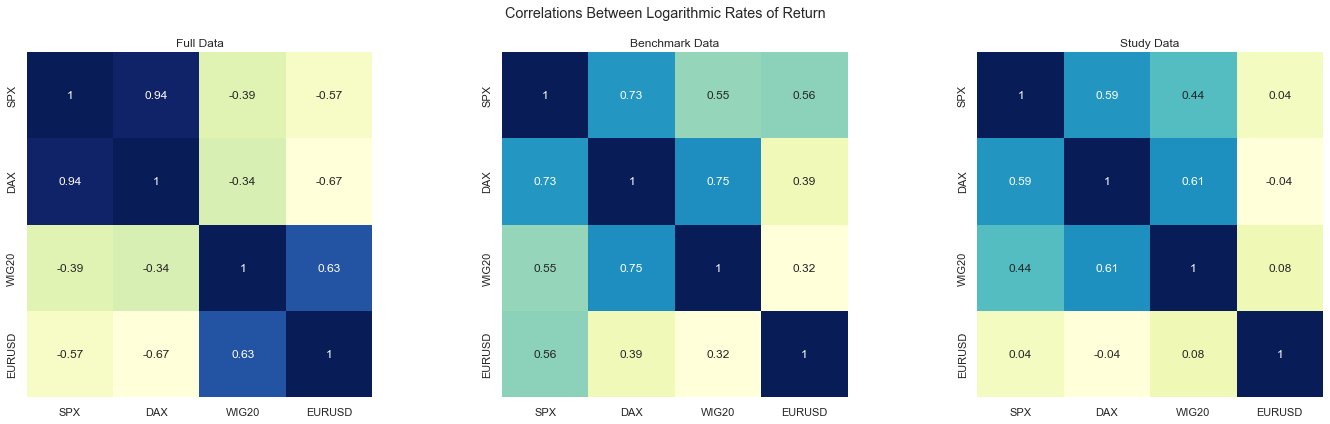

In [15]:
#visual check for correlations
#for discussion on prior parameters choice
sns.set()
fig, ax = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Correlations Between Logarithmic Rates of Return')
sns.heatmap(data_full.dropna().corr().round(2), annot=True, ax=ax[0], cmap="YlGnBu", square=True, cbar=False)
sns.heatmap(data_bench.corr().round(2), annot=True, ax=ax[1], cmap="YlGnBu", square=True, cbar=False)
sns.heatmap(data.corr().round(2), annot=True, ax=ax[2], cmap="YlGnBu", square=True, cbar=False)
ax[0].set_title('Full Data')
ax[1].set_title('Benchmark Data')
ax[2].set_title('Study Data')

fig.tight_layout()
plt.show()
fig.savefig('correlations.pdf', bbox_inches='tight')

/Users/magdalenanitefor/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


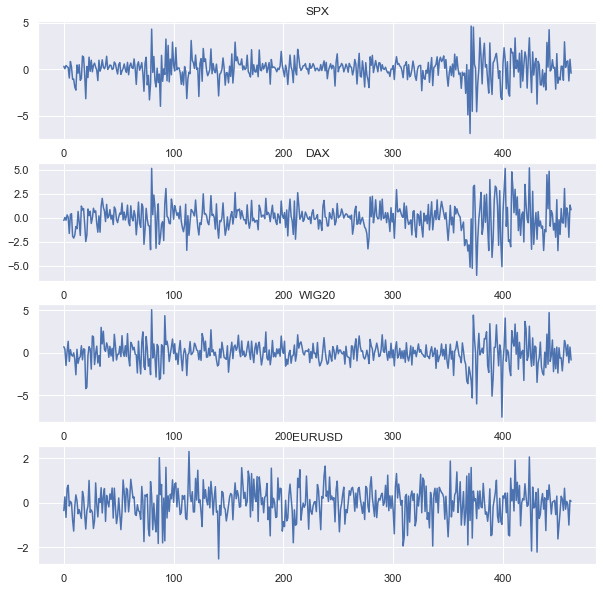

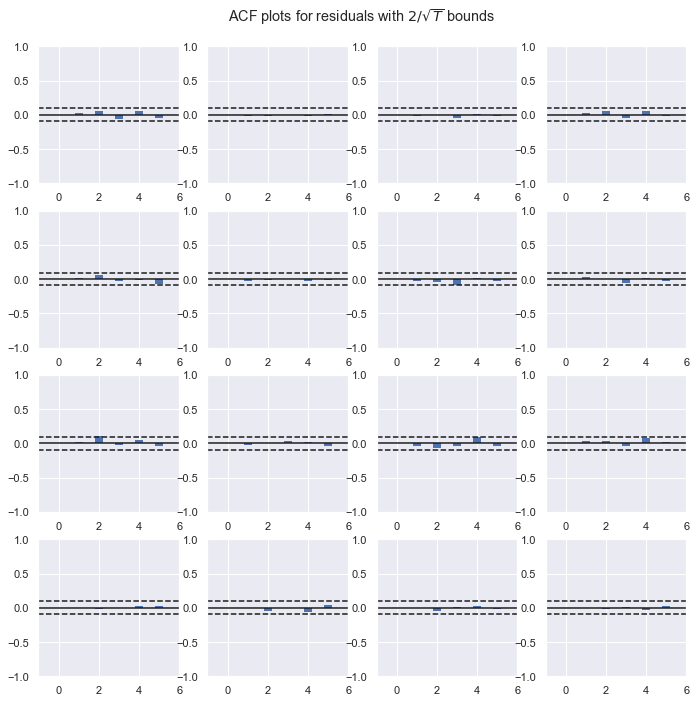

In [16]:
#VAR model for benchmark study
from statsmodels.tsa.api import VAR

#VAR model
var_model = VAR(data_bench)
var_results = var_model.fit(maxlags=5, ic='bic')
var_results.summary()
var_results.plot()
var_results.plot_acorr(nlags=5)

#VAR model residuals
data_bench_resid = var_results.resid
data_bench_resid.to_csv('bench_resid.csv')

In [17]:
#var_results.plot_acorr(nlags=5).savefig('var_acorr.png', bbox_inches='tight')

In [18]:
var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Jun, 2022
Time:                     22:15:31
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                  -0.426559
Nobs:                     462.000    HQIC:                 -0.535103
Log likelihood:          -2462.31    FPE:                   0.545755
AIC:                    -0.605588    Det(Omega_mle):        0.522755
--------------------------------------------------------------------
Results for equation SPX
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.041785         0.060872            0.686           0.492
L1.SPX           -0.205799         0.075459           -2.727           0.006
L1.DAX            0.141369         0.075366            1.876           0.061
L

In [19]:
#benchmark study for DCC-GARCH
from arch import arch_model
benchmark_parameters = []

for i in columns:
    model = arch_model(data_bench_resid[i], p=1, q=1, vol='GARCH', dist='skewt').fit(update_freq=5, disp='off')
    for j in range(1,4):
        benchmark_parameters.append((model.params[j], model.std_err[j]))

In [20]:
parameters = ['omega_','alpha_','beta_']
rows = []
for i in columns:
    for j in parameters:
        rows.append(j+i)

In [21]:
bp = pd.DataFrame(benchmark_parameters, columns=['Coeff','SD'], index=rows)
bp.index = sorted(bp.index.values, key=lambda s: s.lower())
bp

,Coeff,SD
alpha_DAX,0.023122,0.015472
alpha_EURUSD,0.117395,0.039619
alpha_SPX,0.882605,0.034267
alpha_WIG20,0.046696,0.036756
beta_DAX,0.114750,0.053159
beta_EURUSD,0.869239,0.060134
beta_SPX,0.027462,0.018817
beta_WIG20,0.067125,0.027637
omega_DAX,0.919674,0.030620
omega_EURUSD,0.012545,0.015016


In [22]:
#unconditional alpha and beta from a DCC-GARCH model for residuals of VAR benchmark model
bp_uncond = pd.read_csv('dcc_bench_coeffs.csv', names=['Coeff'], index_col=0)
bp_uncond = bp_uncond.iloc[-2:]
bp_uncond['Coeff'] = bp_uncond['Coeff'].astype(float)
bp_uncond['SD'] = 0.1
bp_uncond

,Coeff,SD
[Joint]dcca1,0.012303,0.1
[Joint]dccb1,0.970017,0.1


In [23]:
columns_extended = ['SPX','DAX','WIG20','EURUSD', 'uncond']

<Figure size 100x100 with 0 Axes>

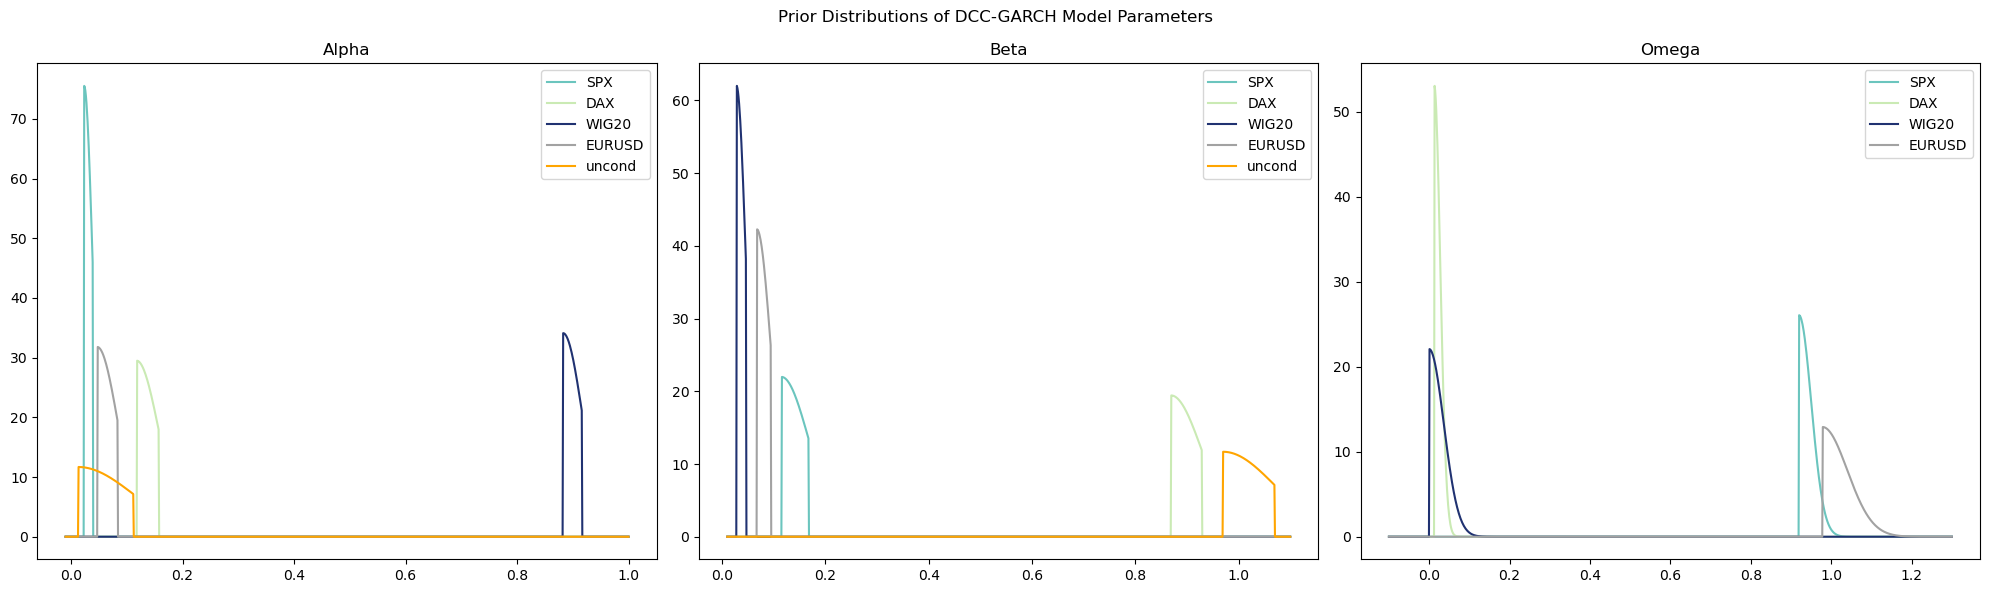

In [24]:
#plot prior distributions
from scipy.stats import truncnorm, binom

plt.style.use('default')
plt.figure(figsize=(1,1), dpi=100)
fig, ax = plt.subplots(1, 3, dpi=100, figsize=(20,6))
palette=['#6bc5be','#caeab4','#203271','#a2a2a2']
fig.suptitle('Prior Distributions of DCC-GARCH Model Parameters')
ax[0].set_title('Alpha')
ax[1].set_title('Beta')
ax[2].set_title('Omega')
#ax[3].set_title('Nu')

def plot_tnormal(i, x, loc, scale, c):
    if (i==2):
        ax[i].plot(x, truncnorm.pdf(x, 0, 20, loc=loc, scale=scale), c=c)
    else:
        ax[i].plot(x, truncnorm.pdf(x, 0, 1, loc=loc, scale=scale), c=c)
    ax[i].legend(columns_extended, loc='upper right')
    
alpha_linspace = np.linspace(-.01,1,1000)
beta_linspace = np.linspace(.01,1.1,1000)

#for alpha_i, beta_i, omega_i from univariate GARCH(1,1)
for i in range(len(rows)):
    if (i <= 3): #alpha
        plot_tnormal(0, alpha_linspace, bp.iloc[i]['Coeff'], bp.iloc[i]['SD'], palette[i%4])
    if ((i > 3) & (i <= 7)): #beta
        plot_tnormal(1, beta_linspace, bp.iloc[i]['Coeff'], bp.iloc[i]['SD'], palette[i%4])
    if (i > 7): #omega
        plot_tnormal(2, np.linspace(-.1, 1.3, 1000), bp.iloc[i]['Coeff'], bp.iloc[i]['SD'], palette[i%4])

#for unconditional alpha, beta
plot_tnormal(0, alpha_linspace, bp_uncond['Coeff'].iloc[0], .1, 'orange')
plot_tnormal(1, beta_linspace, bp_uncond['Coeff'].iloc[1], .1, 'orange')

#Nu from truncated Normal 0;+inf
#ax[3].plot(np.linspace(-.01,20,1000), truncnorm.pdf(np.linspace(-.01,10,1000), 0, 100), color="#6bc5be")

plt.tight_layout()
plt.show()
fig.savefig('priors.pdf', bbox_inches='tight')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c4bd6bd-ba5a-4979-95dc-ea654644e14c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>